In [1]:
from keras import regularizers   
from keras.layers import Dense, Activation, Dropout 
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer 
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, auc, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt 
import email
import mailparser
import numpy as np
import pandas as pd
import re

Using TensorFlow backend.


In [2]:
df = pd.read_excel('../data/raw/Training Data set Updated 11-Jul-2019.xlsx', header=2)

In [3]:
df.head(2)

,Subject,Service Type 1,Service Type 2,Mail Body
0,Re: Pending Documents - Grab Greco,GTL_Queries,Renewals,"Hi Nikhil,\r\n\r\nPlease find the same attache..."
1,Anarock Group -GTL Addition / Deletion - Dec...,GTL_Policy Servicing,Addition/Deletion,"Dear all,\r\n\r\nPlease find the below Correct..."


In [4]:
df.dtypes

Subject           object
Service Type 1    object
Service Type 2    object
Mail Body         object
dtype: object

In [5]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [6]:
df['email'] = df[['subject', 'mail_body']].apply(lambda x: ' '.join([str(x[0]), str(x[1])]), axis=1)

In [7]:
categories = (df['service_type_1']
              .value_counts()
              .where(lambda x: x > 50)
              .dropna()
              .index
              .tolist())

In [8]:
def clean(email):
    email = re.sub(r"\n+", ". ", email)
    email = re.sub(r"\'s", "", email)
    email = re.sub(r"\'ve", "", email)
    email = re.sub(r"n\'t", "", email)
    email = re.sub(r"\'re", "", email)
    email = re.sub(r"\'d", "", email)
    email = re.sub(r"\'ll", "", email)
    email = re.sub(r",", "", email)
    email = re.sub(r"!", " ! ", email)
    email = re.sub(r"\(", "", email)
    email = re.sub(r"\)", "", email)
    email = re.sub(r"\?", "", email)
    email = re.sub(r"'", "", email)
    email = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", email)
    email = re.sub(r"[0-9]\w+|[0-9]","", email)
    email = re.sub(r"\s{2,}", " ", email)
    email = email.strip().lower()
    email = [word for word in email.split() if word not in ENGLISH_STOP_WORDS]
    email = ' '.join(email)
    return email

In [9]:
model_df = df[df['service_type_1'].isin(categories)].copy()

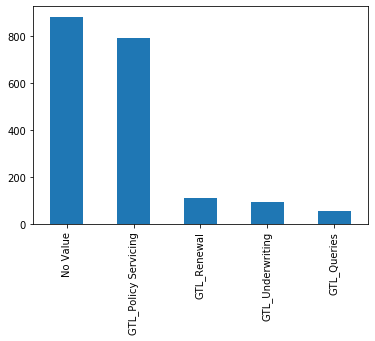

In [10]:
model_df['service_type_1'].value_counts().plot(kind='bar')

In [11]:
model_df['processed_email'] = model_df['email'].apply(clean)

In [12]:
model_df.drop(['service_type_2'], axis=1, inplace=True)

In [13]:
lb = LabelBinarizer()
lb.fit(model_df['service_type_1'])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [14]:
lb.classes_

array(['GTL_Policy Servicing', 'GTL_Queries', 'GTL_Renewal',
       'GTL_Underwriting', 'No Value'], dtype='<U20')

In [15]:
train, test = train_test_split(model_df, test_size=0.2, stratify=model_df['service_type_1'], random_state=1310)

In [16]:
X_train_raw = train['processed_email'].copy()
X_test_raw = test['processed_email'].copy()
y_train = lb.transform(train['service_type_1'])
y_test = lb.transform(test['service_type_1'])

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_raw)

In [18]:
X_train = tokenizer.texts_to_matrix(X_train_raw, mode='tfidf')
X_test = tokenizer.texts_to_matrix(X_test_raw, mode='tfidf')

In [19]:
def fully_connected_mlp():
    model = Sequential()
    model.add(Dense(100, input_shape=(X_train.shape[1],)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(len(lb.classes_)))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [21]:
%%time
model = fully_connected_mlp()
history = model.fit(X_train, y_train, batch_size=100, epochs=20, verbose=0, validation_split=0.1)

CPU times: user 13.5 s, sys: 1.72 s, total: 15.2 s
Wall time: 6.59 s


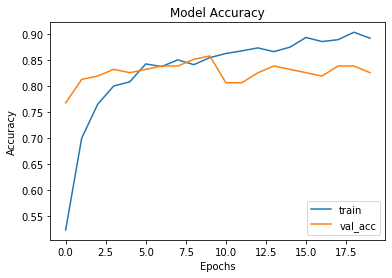

In [22]:
# training accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val_acc'], loc='lower right')
# plt.savefig('../reports/figures/mclf_model_metrics_v1.1.png', format='png')
plt.show()

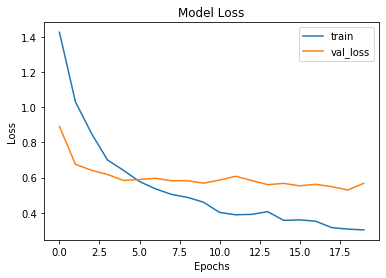

In [23]:
# training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val_loss'], loc='upper right')
# plt.savefig('../reports/figures/mclf_model_metrics_v1.1.png', format='png')
plt.show()

In [24]:
print(f"Training accuracy: {np.mean(history.history['acc']):.2}%")

Training accuracy: 0.83%


In [25]:
# Test data
scores = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {scores[1]:.2}%")

Test accuracy: 0.8%


In [26]:
y_hat_test = [lb.classes_[pred] for pred in model.predict_classes(X_test)] 

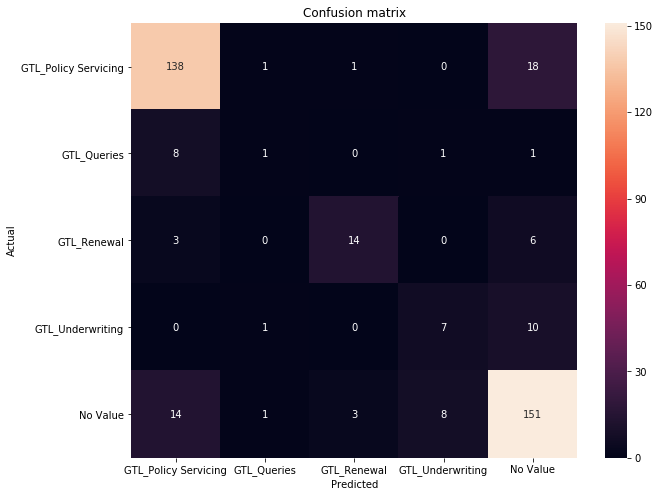

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_matrix(test['service_type_1'], y_hat_test), 
            annot=True, fmt='',
            xticklabels=lb.classes_,
            yticklabels=lb.classes_, ax=ax)
ax.set(title='Confusion matrix', xlabel='Predicted', ylabel='Actual')
plt.show()